# Model Training
Objective:
The goal of this notebook is to train predictive models that identify customers likely to close their credit card accounts (AttritionFlag) using the processed and feature-engineered dataset.

Dataset:
- Processed datasets: `train.csv` and `test.csv`

- Features include demographic, transaction, card type, and engineered variables.

- Categorical variables are already handled in the data cleaning stage.

Workflow – Model Training:
1. Load Data
- Load `train.csv` and `test.csv`
- Separate features (`X`) and target (`y`)

2. Handle Class Imbalance
- Apply SMOTE on the training set to balance the minority class.

3. Train Classification Models
- Train at least two models:
  - Logistic Regression (baseline linear model)
  - Random Forest
  - XGBoost (gradient boosting model to capture non-linearities and interactions)
- Perform hyperparameter tuning and cross-validation to optimize each model.

Next Steps:
- The trained models will be saved and later evaluated in a separate notebook using metrics such as accuracy, precision, recall, F1-score, ROC-AUC, and confusion matrix.

In [1]:
import pandas as pd

# Paths to the saved CSVs
train_path = r'..\..\data\processed\train.csv'
test_path  = r'..\..\data\processed\test.csv'

# Load the CSVs
train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

# Split into features and target
X_train = train_df.drop(columns=['AttritionFlag'])
y_train = train_df['AttritionFlag']

X_test  = test_df.drop(columns=['AttritionFlag'])
y_test  = test_df['AttritionFlag']

# Optional: check shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (80000, 88)
y_train shape: (80000,)
X_test shape: (20000, 88)
y_test shape: (20000,)


## 1. Handling Class Imbalance

In [2]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to training data
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

train_save = X_train_res.copy()
train_save['AttritionFlag'] = y_train_res
train_save.to_csv(r'..\..\data\processed\train_after_smote.csv', index=False)

# Check the new class distribution
print("Before SMOTE:")
print(y_train.value_counts())
print("\nAfter SMOTE:")
print(y_train_res.value_counts())

# Optional: check shapes
print("\nX_train_res shape:", X_train_res.shape)
print("y_train_res shape:", y_train_res.shape)

Before SMOTE:
AttritionFlag
0    76032
1     3968
Name: count, dtype: int64

After SMOTE:
AttritionFlag
0    76032
1    76032
Name: count, dtype: int64

X_train_res shape: (152064, 88)
y_train_res shape: (152064,)


## 2. Logistic Regression Training

In [3]:
from sklearn.preprocessing import StandardScaler

# Fit scaler on training data and transform both training and test
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from tqdm import tqdm
import numpy as np


# Define Logistic Regression
lr = LogisticRegression(solver='lbfgs', max_iter=2000, random_state=42, class_weight='balanced')

# Hyperparameter candidates
param_grid = {'C': [0.1, 1, 10]}

# Stratified K-Fold
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Store results
results = []

# Total number of fits
total_fits = len(param_grid['C']) * cv.get_n_splits()
pbar = tqdm(total=total_fits, desc="GridSearchCV Progress")

# Loop through hyperparameters
for C_val in param_grid['C']:
    lr.set_params(C=C_val)
    # Evaluate with cross-validation using scaled features
    scores = cross_val_score(lr, X_train_res_scaled, y_train_res, cv=cv, scoring='roc_auc', n_jobs=-1)
    results.append({
        'C': C_val,
        'mean_cv_roc_auc': np.mean(scores)
    })
    pbar.update(cv.get_n_splits())  # Update progress bar for each fold set

pbar.close()

# Find best hyperparameter
best_result = max(results, key=lambda x: x['mean_cv_roc_auc'])
best_lr = LogisticRegression(
    C=best_result['C'], solver='lbfgs', max_iter=2000,
    random_state=42, class_weight='balanced'
)
best_lr.fit(X_train_res_scaled, y_train_res)

print("Best Hyperparameters:", best_result)
print("Best CV ROC-AUC:", best_result['mean_cv_roc_auc'])

GridSearchCV Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:27<00:00,  3.09s/it]


Best Hyperparameters: {'C': 0.1, 'mean_cv_roc_auc': np.float64(0.969252097867352)}
Best CV ROC-AUC: 0.969252097867352


In [5]:
from sklearn.linear_model import LogisticRegression

best_lr = LogisticRegression(C=1, solver='lbfgs', max_iter=2000, random_state=42)
best_lr.fit(X_train_res_scaled, y_train_res)


LogisticRegression(C=1, max_iter=2000, random_state=42)

In [6]:
# Predicted probabilities (for ROC-AUC)
y_pred_prob = best_lr.predict_proba(X_test_scaled)[:, 1]

# Predicted class labels
y_pred = best_lr.predict(X_test_scaled)

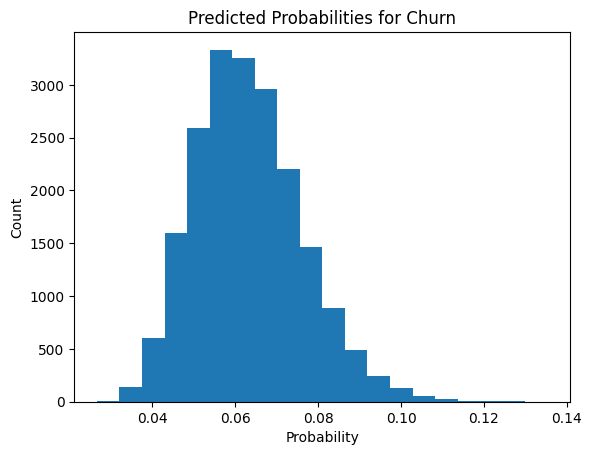

In [7]:
import matplotlib.pyplot as plt

plt.hist(y_pred_prob, bins=20)
plt.title("Predicted Probabilities for Churn")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.show()

### *Reusable Code for Evaluating Models*

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def evaluate_and_plot(model, X_test, y_test, model_name, save_dir):
    """
    Evaluate a classification model and save a confusion matrix heatmap.
    
    Parameters:
    - model: trained sklearn/xgboost model
    - X_test: test features
    - y_test: true labels
    - model_name: string (e.g. "Logistic Regression", "Random Forest")
    - save_dir: directory path to save the heatmap
    """
    
    # Predict labels
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_pred_prob)

    # Print results
    print(f"=== {model_name} ===")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)

    # Ensure save path exists
    os.makedirs(save_dir, exist_ok=True)

    # Plot confusion matrix heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Predicted 0", "Predicted 1"],
                yticklabels=["Actual 0", "Actual 1"])
    plt.title(f"Confusion Matrix Heatmap ({model_name})")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")

    # Save figure
    filename = f"{model_name.lower().replace(' ', '_')}_conf_matrix.png"
    plt.savefig(os.path.join(save_dir, filename), dpi=300, bbox_inches="tight")
    plt.show()

=== Logistic Regression ===
Accuracy:  0.9504
Precision: 0.0000
Recall:    0.0000
F1-score:  0.0000
ROC-AUC:   0.5088
Confusion Matrix:
 [[19008     0]
 [  992     0]]


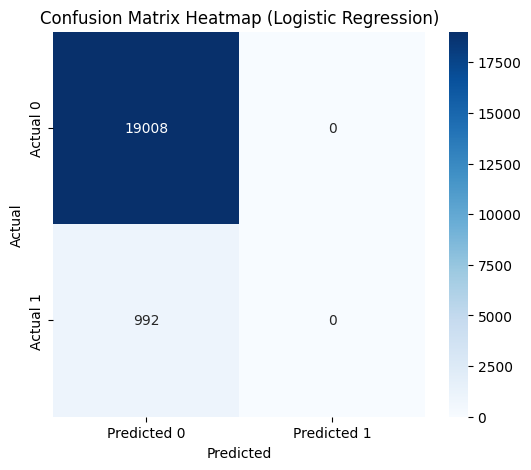

In [16]:
evaluate_and_plot(best_lr, X_test_scaled, y_test, "Logistic Regression", save_path)

## Logistic Regression Model Evaluation — Summary

**Test Results:**
- **Accuracy:** 95.04% (misleading due to imbalance)
- **Precision / Recall / F1-score:** 0.0 (model never predicted churn)
- **ROC-AUC:** 0.5088 (almost random performance)

**Key Takeaway:**  
High accuracy here is misleading since the model completely fails to detect churn and has no meaningful predictive power.

## 3. Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from tqdm import tqdm
import numpy as np

# ----------------------
# Define Random Forest
# ----------------------
rf = RandomForestClassifier(
    n_estimators=200,        # number of trees
    random_state=42,
    class_weight='balanced', # handle imbalanced training data
    n_jobs=-1
)

# ----------------------
# Hyperparameter candidates
# ----------------------
param_grid = {
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10]
}

# Stratified K-Fold
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Store results
results = []

# Total number of fits for progress bar
total_fits = len(param_grid['max_depth']) * len(param_grid['min_samples_split']) * cv.get_n_splits()
pbar = tqdm(total=total_fits, desc="Random Forest GridSearchCV")

# ----------------------
# Loop through hyperparameters
# ----------------------
for depth in param_grid['max_depth']:
    for min_split in param_grid['min_samples_split']:
        rf.set_params(max_depth=depth, min_samples_split=min_split)
        scores = cross_val_score(rf, X_train_res, y_train_res, cv=cv, scoring='roc_auc', n_jobs=-1)
        results.append({
            'max_depth': depth,
            'min_samples_split': min_split,
            'mean_cv_roc_auc': np.mean(scores)
        })
        pbar.update(cv.get_n_splits())

pbar.close()

# ----------------------
# Find best hyperparameters
# ----------------------
best_result = max(results, key=lambda x: x['mean_cv_roc_auc'])
best_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=best_result['max_depth'],
    min_samples_split=best_result['min_samples_split'],
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
best_rf.fit(X_train_res, y_train_res)

print("Best Hyperparameters:", best_result)
print("Best CV ROC-AUC:", best_result['mean_cv_roc_auc'])

Random Forest GridSearchCV: 100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [38:29<00:00, 85.54s/it]


Best Hyperparameters: {'max_depth': None, 'min_samples_split': 2, 'mean_cv_roc_auc': np.float64(0.9924860336957072)}
Best CV ROC-AUC: 0.9924860336957072


D:\Projects\Github Repo\Churn-Prediction-for-Credit-Card-Holders-Using-Predictive-Analytics\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
D:\Projects\Github Repo\Churn-Prediction-for-Credit-Card-Holders-Using-Predictive-Analytics\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


=== Random Forest ===
Accuracy:  0.9504
Precision: 0.0000
Recall:    0.0000
F1-score:  0.0000
ROC-AUC:   0.5194
Confusion Matrix:
 [[19008     0]
 [  992     0]]


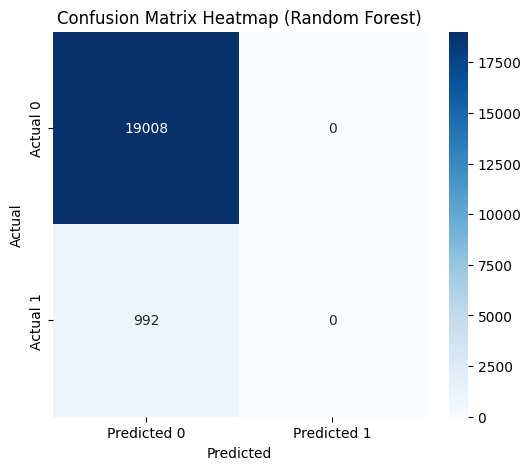

In [17]:
# Random Forest Evaluation
evaluate_and_plot(best_rf, X_test_scaled, y_test, "Random Forest", save_path)

## Random Forest Model Evaluation

**Interpretation:**
- The model predicts **only the majority class** (non-churn).
- High accuracy is misleading.
- Precision, Recall, and F1 are all **zero**, meaning no churn cases were identified.
- ROC-AUC slightly above 0.5 → performance is almost random.
- This indicates **poor predictive power**; features may not strongly correlate with churn.

## 4. XGBoost

In [14]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from tqdm import tqdm
import numpy as np

# ----------------------
# Define XGBoost Classifier
# ----------------------
xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    scale_pos_weight=1,   # handle imbalance (can adjust ratio if needed)
    n_jobs=-1
)

# ----------------------
# Hyperparameter candidates
# ----------------------
param_grid = {
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200]
}

# Stratified K-Fold
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Store results
results = []

# Total fits for progress bar
total_fits = (
    len(param_grid['max_depth']) *
    len(param_grid['learning_rate']) *
    len(param_grid['n_estimators']) *
    cv.get_n_splits()
)
pbar = tqdm(total=total_fits, desc="XGBoost GridSearchCV")

# ----------------------
# Loop through hyperparameters
# ----------------------
for depth in param_grid['max_depth']:
    for lr in param_grid['learning_rate']:
        for n_est in param_grid['n_estimators']:
            xgb.set_params(max_depth=depth, learning_rate=lr, n_estimators=n_est)
            scores = cross_val_score(
                xgb, X_train_res, y_train_res,
                cv=cv, scoring='roc_auc', n_jobs=-1
            )
            results.append({
                'max_depth': depth,
                'learning_rate': lr,
                'n_estimators': n_est,
                'mean_cv_roc_auc': np.mean(scores)
            })
            pbar.update(cv.get_n_splits())

pbar.close()

# ----------------------
# Find best hyperparameters
# ----------------------
best_result = max(results, key=lambda x: x['mean_cv_roc_auc'])
best_xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    scale_pos_weight=1,
    n_jobs=-1,
    max_depth=best_result['max_depth'],
    learning_rate=best_result['learning_rate'],
    n_estimators=best_result['n_estimators']
)
best_xgb.fit(X_train_res, y_train_res)

print("Best Hyperparameters:", best_result)
print("Best CV ROC-AUC:", best_result['mean_cv_roc_auc'])

XGBoost GridSearchCV: 100%|████████████████████████████████████████████████████████████████████████████████████████| 54/54 [06:51<00:00,  7.62s/it]
D:\Projects\Github Repo\Churn-Prediction-for-Credit-Card-Holders-Using-Predictive-Analytics\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:14:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Hyperparameters: {'max_depth': 10, 'learning_rate': 0.3, 'n_estimators': 200, 'mean_cv_roc_auc': np.float64(0.9861831999764054)}
Best CV ROC-AUC: 0.9861831999764054


=== XGBoost ===
Accuracy:  0.9504
Precision: 0.0000
Recall:    0.0000
F1-score:  0.0000
ROC-AUC:   0.5035
Confusion Matrix:
 [[19008     0]
 [  992     0]]


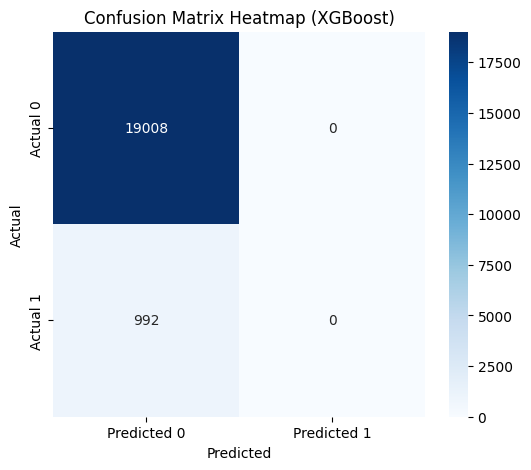

In [18]:
# XGBoost
evaluate_and_plot(best_xgb, X_test_scaled, y_test, "XGBoost", save_path)

### XGBoost Results  

- **Accuracy ≈ 95%** (misleading due to class imbalance)  
- **Precision / Recall / F1-score for churners = 0.0**  
- **ROC-AUC ≈ 0.50** — close to random guessing  

**Interpretation:**  
Despite being a powerful boosting algorithm, **XGBoost performed no better than Logistic Regression or Random Forest**.  
It also defaulted to predicting only the majority class (non-churn), failing to capture any meaningful signal from the features.  

**Key Takeaway:**  
The poor performance confirms that the **dataset itself lacks predictive power** for churn, and that even advanced models like XGBoost cannot overcome this limitation without richer features.

# Project Conclusion: Churn Prediction for Credit Card Holders

## Summary of Findings
**Logistic Regression**, **Random Forest**, and **XGBoost** models were trained on the dataset with balanced training data (via SMOTE) and tested on the test data.

### Model Performances:
- **Accuracy**: ~95% (misleading due to class imbalance)
- **Precision / Recall / F1-score**: All **0.0** — no churn cases were identified by either model.
- **ROC-AUC**: ~0.51–0.52, only slightly better than random guessing.

### Interpretation:
- Despite feature engineering, tuning hyperparameters, and balancing the training data, both models defaulted to predicting only the majority class (non-churn).
- This indicates **no strong predictive signal** in the available features to separate churn from non-churn customers.
- High accuracy is purely a result of the majority class dominating the dataset, not actual predictive performance.

## Final Conclusion
The dataset, in its current form, **does not contain sufficient or relevant features** to build a model that can reliably predict customer attrition/churn.  
Future work should focus on **collecting richer, more behaviorally informative features** and possibly **reshaping the problem definition** before applying predictive modeling.
